In [0]:
import argparse
import yaml
import time
import datetime
import cv2
import numpy as np
import pandas as pd
import random

from skimage import io, transform
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy import ndimage, misc

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch
from torch.autograd import Variable
import torch.optim as optim

from google.colab import drive
import os
import warnings
from collections import defaultdict

In [2]:
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/Mosquito-Tec')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### Dataset functions
def paddedzoom(img, zoomfactor = 0.8):
    out  = np.zeros_like(img)
    zoomed = cv2.resize(img, None, fx = zoomfactor, fy = zoomfactor)
    
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    if zoomfactor < 1:    
        out[int((h - zh) / 2):int(-(h - zh) / 2), 
            int((w - zw) / 2):int(-(w - zw) / 2), :] = zoomed
    else:
        out = zoomed[int((zh - h) / 2):int(-(zh - h) / 2), 
                     int((zw - w) / 2):int(-(zw - w) / 2), :]

    return out

class SentinelDataset(Dataset):

    def __init__(self, csv_file, root_dir, selected_sentinel, sentinel_columns, categorical_columns, numerical_columns, output_columns, training = True, transform = None):
        self.sentinel_frame = pd.read_csv(csv_file)

        self.sentinel_frame = self.sentinel_frame[sentinel_columns] 

        self.sentinel_frame["TRAPSET"]= pd.to_datetime(self.sentinel_frame["TRAPSET"]).dt.week
        self.sentinel_frame["TRAPCOLLECT"]= pd.to_datetime(self.sentinel_frame["TRAPCOLLECT"]).dt.week
        self.selected_sentinel = selected_sentinel

        self.outputs = output_columns
        self.categorical_columns = categorical_columns
        self.numerical_columns = numerical_columns


        for category in self.categorical_columns:
            self.sentinel_frame[category] = self.sentinel_frame[category].astype('category')


        #print(self.sentinel_frame.dtypes)
        self.root_dir = root_dir
        self.transform = transform
        self.training = training
        self.mean = np.array([[[0.0188]],[[0.0181]],[[0.0226]]])
        self.std =  np.array([[[0.0190]],[[0.0193]],[[0.0191]]])

    def getEmbeddingSize(self):
        categorical_column_sizes = [len(self.sentinel_frame[column].cat.categories) for column in self.categorical_columns]
        embedding_sizes = [(col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_column_sizes]

        return embedding_sizes

    def __len__(self):
        return len(self.sentinel_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = str('data' + str(self.sentinel_frame.iloc[idx, 0]) + '.npy')

        img_name = os.path.join(self.root_dir, filename)
        image = np.load(img_name)[self.selected_sentinel].astype(np.float32) / 65536

        #normalization
        #image = (image - self.mean)/self.std 
        image /= image.max()

        if self.training:
            #random flip
            if np.random.rand() > 0.5:
                image = np.flip(image, axis = 2).copy()

            #random rotate
            image = ndimage.rotate(image, random.randint(-20, 20), axes = [1, 2],
                                   reshape = False)

            # random zoom
            or_image = image.copy()
            image =  np.swapaxes(image,0,2)
            image = paddedzoom(image, 1.0 + (np.random.rand()/2) )
            image =  np.swapaxes(image,0,2)
            if image.shape != or_image.shape:
                image = or_image

        if self.transform:
            image = self.transform(image)

        target = self.sentinel_frame.iloc[idx, -1]
        image = torch.from_numpy(image)

        current_row = self.sentinel_frame.iloc[[idx]]
        ats = []
        for category in self.categorical_columns:
            ats.append(current_row[category].cat.codes.values)

        categorical_data = np.stack(ats, 1)
        numerical_data = np.stack([current_row[col].values for col in self.numerical_columns], 1)

        numerical_data = torch.from_numpy(numerical_data)

        return image, categorical_data, numerical_data, target

In [0]:
def crop(x, th, tw):
        _, _, w, h = x.size()
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return x[:, :, x1:x1 + tw, y1:y1 + th]

In [0]:
# Columns

sentinel_columns = ["OBJECTID", "TRAPTYPE", "ATTRACTANTSUSED", "LATITUDE","LONGITUDE", 
                    "TRAPSET", "SETTIMEOFDAY","TRAPCOLLECT", "COLLECTTIMEOFDAY", "GENUS",
                    "SPECIES", "icon", "sunriseTime","sunsetTime", "moonPhase", 
                    "precipIntensity","precipIntensityMax", "precipProbability", 
                    "temperatureHigh", "temperatureHighTime", "temperatureLow", 
                    "temperatureLowTime","apparentTemperatureHigh", "apparentTemperatureHighTime", 
                    "apparentTemperatureLow","apparentTemperatureLowTime", "dewPoint", 
                    "humidity", "pressure", "windSpeed", "windGust","windGustTime", 
                    "windBearing", "cloudCover","uvIndex", "uvIndexTime", "visibility", 
                    "temperatureMin", "temperatureMinTime", "temperatureMax", "temperatureMaxTime", 
                    "apparentTemperatureMin", "apparentTemperatureMinTime","apparentTemperatureMax", 
                    "apparentTemperatureMaxTime", "TOTAL"]

output_columns = ['TOTAL']

total_categorical_columns = ['TRAPTYPE', 'ATTRACTANTSUSED', 'SETTIMEOFDAY', 'COLLECTTIMEOFDAY', 
                       'GENUS', 'SPECIES', 'icon']

categorical_columns = ['TRAPTYPE', 'ATTRACTANTSUSED', 'SETTIMEOFDAY', 'COLLECTTIMEOFDAY', 
                       'GENUS', 'SPECIES', 'icon']

total_numerical_columns = ['TRAPSET', 'TRAPCOLLECT', 'sunriseTime', 'sunsetTime', 'moonPhase', 
                     'precipIntensity', 'precipIntensityMax', 'precipProbability', 
                     'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 
                     'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime',
                     'apparentTemperatureLow', 'apparentTemperatureLowTime', 'dewPoint', 
                     'humidity', 'pressure', 'windSpeed', 'windGust', 'windGustTime', 
                     'windBearing', 'cloudCover', 'uvIndex', 'uvIndexTime','visibility', 
                     'temperatureMin', 'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 
                     'apparentTemperatureMin','apparentTemperatureMinTime', 'apparentTemperatureMax', 
                     'apparentTemperatureMaxTime']

numerical_columns = ['TRAPSET', 'TRAPCOLLECT', 'sunriseTime', 'sunsetTime', 'moonPhase', 
                     'precipIntensity', 'precipIntensityMax', 'precipProbability', 
                     'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 
                     'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime',
                     'apparentTemperatureLow', 'apparentTemperatureLowTime', 'dewPoint', 
                     'humidity', 'pressure', 'windSpeed', 'windGust', 'windGustTime', 
                     'windBearing', 'cloudCover', 'uvIndex', 'uvIndexTime','visibility', 
                     'temperatureMin', 'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 
                     'apparentTemperatureMin','apparentTemperatureMinTime', 'apparentTemperatureMax', 
                     'apparentTemperatureMaxTime']

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

train_data = SentinelDataset(csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_train.csv',
                             root_dir = '/content/drive/My Drive/Colab/mosquito/data_mosquito2/', 
                             selected_sentinel = [2, 3, 4],
                             sentinel_columns = sentinel_columns, categorical_columns = categorical_columns, 
                             numerical_columns = numerical_columns, output_columns = output_columns,
                             training = True)

test_data = SentinelDataset(csv_file = '/content/drive/My Drive/Colab/mosquito/Final_Mosquito_test.csv',
                            root_dir = '/content/drive/My Drive/Colab/mosquito/data_mosquito2/', 
                            selected_sentinel = [2, 3, 4],
                            sentinel_columns = sentinel_columns, categorical_columns = categorical_columns, 
                            numerical_columns = numerical_columns, output_columns = output_columns, training = False)

# Get embedding sizes
embedding_sizes = train_data.getEmbeddingSize()

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
    sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
    sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, 
    num_workers = num_workers)

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


torch.Size([32, 3, 104, 104])


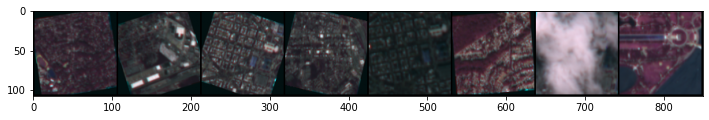

In [20]:
dataiter = iter(train_loader)
# the "_" is a placeholder for no labels
images, _, _, _ = dataiter.next()
print(images.shape)

# show images
fig = plt.figure(figsize=(12, 8))
images = images[0:8, :, :, :]
blue = torch.from_numpy(cv2.normalize(images[:, 0, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
green = torch.from_numpy(cv2.normalize(images[:, 1, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
red = torch.from_numpy(cv2.normalize(images[:, 2, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)

images[:, 0, :, :] = red
images[:, 1, :, :] = green
images[:, 2, :, :] = blue

imshow(torchvision.utils.make_grid(images))

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [0]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, c, z_dim, n_latent):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            nn.Conv2d(c, 32, 4, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 4, 2, padding=1),
            nn.LeakyReLU(),
            Flatten(),
            nn.Linear(64 * z_dim**2, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, n_latent)
        ])
        
    def forward(self, x):
        i = 1
        for layer in self.model:
            x = layer(x)
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, c, z_dim, n_latent):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            nn.Linear(n_latent, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64 * z_dim**2),
            nn.ReLU(),
            Reshape((64, z_dim, z_dim,)),
            nn.ConvTranspose2d(64, 32, 4, 2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, c, 4, 2, padding=1),
            nn.Sigmoid()
        ])
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

In [0]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) / float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [0]:
class MMD_VAE(torch.nn.Module):
    def __init__(self, in_shape, n_latent):
        super(MMD_VAE, self).__init__()
        self.in_shape = in_shape
        self.n_latent = n_latent
        self.c, self.h, self.w = in_shape
        self.z_dim = self.h // 2**2
        self.encoder = Encoder(self.c, self.z_dim, self.n_latent)
        self.decoder = Decoder(self.c, self.z_dim, self.n_latent)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        x_reconstructed = crop(x_reconstructed, self.h, self.h)
        return z, x_reconstructed

In [0]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes = [1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes = [1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

def train(model, n_epochs, train_loader, valid_loader, optimizer, device, logs_interval, n_latent):
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()

        for batch_idx, (inputs, _, _, _) in enumerate(train_loader):
            inputs = inputs.to(device)
            true_samples = Variable(
                torch.randn(200, n_latent),
                requires_grad = False
            ).to(device)

            z, output = model(inputs)
            mmd = compute_mmd(true_samples, z)
            nll = (output - inputs).pow(2).mean()
            loss = nll + mmd

            optimizer.zero_grad()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()


            if batch_idx % logs_interval == 0:
                print("Negative log likelihood is {:.5f}, mmd loss is {:.5f}".format(
                        nll.item(), mmd.item()))
                
        model.eval()

        for batch_idx, (inputs, _, _, _) in enumerate(valid_loader):
            inputs = inputs.to(device)
            true_samples = Variable(
                torch.randn(200, n_latent),
                requires_grad = False
            ).to(device)

            z, output = model(inputs)
            mmd = compute_mmd(true_samples, z)
            nll = (output - inputs).pow(2).mean()
            loss = nll + mmd
                
            valid_loss += loss.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'best_selected_vae.pt')
            valid_loss_min = valid_loss

In [0]:
# Model
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

n_latent = 50

model = MMD_VAE((3, 104, 104), n_latent = n_latent).to(device).double()
optimizer = torch.optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters(), lr = 1e-4)

In [28]:
n_epochs = 70

train(model, n_epochs, train_loader, valid_loader, optimizer, device, 20, n_latent)

Negative log likelihood is 0.10259, mmd loss is 0.00063
Negative log likelihood is 0.01589, mmd loss is 0.00103
Negative log likelihood is 0.01195, mmd loss is 0.00059
Epoch: 1 	Training Loss: 0.001287 	Validation Loss: 0.000526
Validation loss decreased (inf --> 0.000526).  Saving model ...
Negative log likelihood is 0.01464, mmd loss is 0.00066
Negative log likelihood is 0.01478, mmd loss is 0.00064
Negative log likelihood is 0.01083, mmd loss is 0.00063
Epoch: 2 	Training Loss: 0.000495 	Validation Loss: 0.000451
Validation loss decreased (0.000526 --> 0.000451).  Saving model ...
Negative log likelihood is 0.01212, mmd loss is 0.00071
Negative log likelihood is 0.01177, mmd loss is 0.00061
Negative log likelihood is 0.01132, mmd loss is 0.00070
Epoch: 3 	Training Loss: 0.000409 	Validation Loss: 0.000396
Validation loss decreased (0.000451 --> 0.000396).  Saving model ...
Negative log likelihood is 0.01158, mmd loss is 0.00067
Negative log likelihood is 0.01256, mmd loss is 0.00055

In [14]:
model.load_state_dict(torch.load('best_selected_vae.pt'))

<All keys matched successfully>

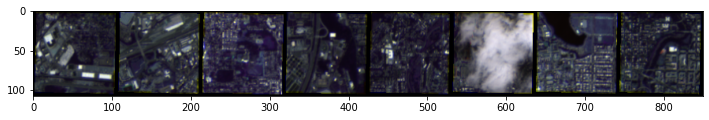

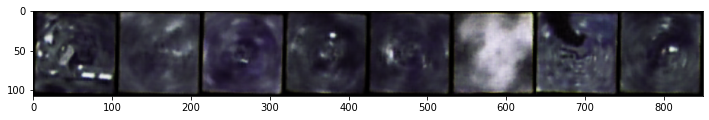

In [31]:
dataiter = iter(test_loader)
# the "_" is a placeholder for no labels
images, _, _, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
images[:, 0, :, :] = torch.from_numpy(cv2.normalize(images[:, 0, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 1, :, :] = torch.from_numpy(cv2.normalize(images[:, 1, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
images[:, 2, :, :] = torch.from_numpy(cv2.normalize(images[:, 2, :, :].numpy(), 
                                                    None, 0, 255, 
                                                    cv2.NORM_MINMAX, 
                                                    dtype = cv2.CV_8U) / 255.)
imshow(torchvision.utils.make_grid(images[0:8, :, :, :]))

_, out = model(images.to(device).double())
fig = plt.figure(figsize=(12, 8))
images2 = out.to('cpu').detach()
imshow(torchvision.utils.make_grid(images2[0:8, :, :, :]))

In [0]:
class LinearModel(nn.Module):
    def __init__(self, n_latent, embedding_sizes, num_numerical_cols):
        super(LinearModel, self).__init__()

        embed_size = 0
        for embed in embedding_sizes:
            embed_size += embed[1]

        self.dense_embed = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(embed_size + num_numerical_cols, 20),
            nn.Sigmoid(),
            nn.Dropout(),
            nn.Linear(20, 20), 
            nn.Sigmoid(),
            nn.Dropout(),
            nn.Linear(20, 10)
        )

        self.dense = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(n_latent + 10, 100),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 1),
            nn.ReLU()
        )

        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_sizes])
        self.batch_norm_linear = nn.BatchNorm1d(num_numerical_cols)
        self.batch_norm_vae = nn.BatchNorm1d(n_latent)

    def forward(self, x, x_categorical, x_numerical):
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embed = e(x_categorical[:, i])
            embeddings.append(embed)


        y = torch.cat(embeddings, 1)
        x_numerical = self.batch_norm_linear(x_numerical)
        y = torch.cat([y, x_numerical], 1)
        x = self.batch_norm_vae(x)

        y = self.dense_embed(y)

        mixtensor = torch.cat((x, y), 1)
        
        out = self.dense(mixtensor)

        return out
        return out

In [0]:
def train_dense(model_vae, model_linear, n_epochs, train_loader, valid_loader, 
                optimizer, criterion, device, logs_interval, n_latent):
    valid_loss_min = np.Inf

    model_vae.eval()

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model_linear.train()

        for batch_idx, (inputs, categorical_data, numerical_data, target) in enumerate(train_loader):
            inputs = inputs.to(device)
            categorical_data = categorical_data.squeeze().type(torch.LongTensor).to(device)
            numerical_data = numerical_data.squeeze().type(torch.double).to(device)
            target = target.squeeze().type(torch.double).to(device)
            
            z, _ = model_vae(inputs)
            
            output = model_linear(z, categorical_data, numerical_data)

            optimizer.zero_grad()
            loss = criterion(output.squeeze(), target)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()


            if batch_idx % logs_interval == 0:
                print("MSE Loss is {:.5f}".format(loss.item()))
                
        model_linear.eval()

        for batch_idx, (inputs, categorical_data, numerical_data, target) in enumerate(valid_loader):
            inputs = inputs.to(device)
            categorical_data = categorical_data.squeeze().type(torch.LongTensor).to(device)
            numerical_data = numerical_data.squeeze().type(torch.double).to(device)
            target = target.squeeze().type(torch.double).to(device)
            
            z, _ = model_vae(inputs)
            
            output = model_linear(z, categorical_data, numerical_data)

            loss = criterion(output.squeeze(), target)
                
            valid_loss += loss.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_linear.state_dict(), 'best_linear_selected_vae.pt')
            valid_loss_min = valid_loss

In [0]:
model_linear = LinearModel(n_latent, embedding_sizes, len(numerical_columns)).to(device).double()
#optimizer_linear = torch.optim.Adam(model_linear.parameters())
criterion_linear = nn.MSELoss()
optimizer_linear = optim.RMSprop(model_linear.parameters(), lr = 1e-4)

In [40]:
n_epochs_linear = 100

train_dense(model, model_linear, n_epochs_linear, train_loader, valid_loader, 
            optimizer_linear, criterion_linear, device, 20, n_latent)

MSE Loss is 314.56250
MSE Loss is 2099.70119
MSE Loss is 239.98550
Epoch: 1 	Training Loss: 28.966604 	Validation Loss: 79.823497
Validation loss decreased (inf --> 79.823497).  Saving model ...
MSE Loss is 229.92639
MSE Loss is 2296.48030
MSE Loss is 208.69361
Epoch: 2 	Training Loss: 28.124831 	Validation Loss: 85.426833
MSE Loss is 236.44431
MSE Loss is 169.61479
MSE Loss is 4484.95739
Epoch: 3 	Training Loss: 27.011402 	Validation Loss: 73.761359
Validation loss decreased (79.823497 --> 73.761359).  Saving model ...
MSE Loss is 4835.79946
MSE Loss is 975.01963
MSE Loss is 343.75657
Epoch: 4 	Training Loss: 25.881758 	Validation Loss: 72.216315
Validation loss decreased (73.761359 --> 72.216315).  Saving model ...
MSE Loss is 263.95957
MSE Loss is 1563.75460
MSE Loss is 110.70352
Epoch: 5 	Training Loss: 24.754981 	Validation Loss: 70.521582
Validation loss decreased (72.216315 --> 70.521582).  Saving model ...
MSE Loss is 342.11272
MSE Loss is 238.88465
MSE Loss is 508.04324
Epoch:

In [18]:
model_linear.load_state_dict(torch.load('best_linear_selected_vae.pt'))

<All keys matched successfully>

In [19]:
from sklearn.metrics import mean_absolute_error

# track test loss
test_loss = 0.0
mean_abs = 0.0

model_linear.eval()
# iterate over test data
#bin_op.binarization()
for batch_idx, (inputs, categorical_data, numerical_data, target) in enumerate(test_loader):
    inputs = inputs.to(device)
    categorical_data = categorical_data.squeeze().type(torch.LongTensor).to(device)
    numerical_data = numerical_data.squeeze().type(torch.double).to(device)
    target = target.squeeze().type(torch.double).to(device)
    
    z, _ = model(inputs)
    
    output = model_linear(z, categorical_data, numerical_data)

    loss = criterion_linear(output.squeeze(), target)
    loss.backward()

    out_np = output.detach().squeeze().cpu().numpy().astype(int).T
    target_np = target.detach().cpu().numpy().astype(int).T

    print([(out, tar) for out, tar in zip(out_np, target_np)])

    mean_abs += mean_absolute_error(out_np, target_np) * batch_size
        
    test_loss += loss.item()

# calculate average losses
test_loss = np.sqrt(test_loss / len(test_loader.dataset))
mean_abs /= len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Mean Abs Loss: {:.6f}\n'.format(mean_abs))


[(14, 21), (14, 25), (15, 3), (13, 27), (12, 22), (13, 23), (10, 5), (9, 4), (13, 2), (10, 3), (9, 17), (9, 9), (11, 4), (10, 2), (14, 2), (14, 5), (14, 5), (12, 11), (10, 8), (13, 7), (9, 4), (15, 4), (12, 4), (13, 2), (13, 5), (12, 4), (14, 27), (17, 7), (12, 12), (14, 5), (11, 5), (12, 3)]
[(13, 4), (13, 18), (12, 5), (12, 5), (9, 19), (13, 2), (13, 21), (13, 4), (13, 8), (11, 9), (16, 13), (11, 5), (15, 19), (14, 22), (10, 2), (11, 8), (12, 11), (9, 12), (10, 15), (21, 15), (15, 18), (11, 2), (12, 13), (13, 3), (11, 4), (10, 5), (9, 2), (16, 6), (13, 5), (12, 27), (11, 5), (10, 3)]
[(10, 3), (15, 3), (11, 3), (13, 40), (13, 5), (15, 29), (13, 10), (11, 20), (10, 3), (14, 3), (12, 12), (18, 16), (10, 4), (8, 3), (10, 4), (13, 6), (12, 90), (10, 6), (12, 56), (9, 3), (9, 7), (10, 18), (13, 3), (11, 111), (12, 7), (10, 8), (12, 16), (11, 6), (15, 14), (12, 29), (16, 8), (12, 5)]
[(13, 7), (15, 3), (9, 4), (9, 33), (9, 3), (11, 161), (14, 3), (16, 5), (12, 6), (18, 10), (15, 15), (12, 

## Mean Errors per Configuration

### 1. Full Sentinel (70 dims) + [humidity, genus, species, temperaturemax, temperaturehigh, uv_index]

 * Mean Squared Error: 19.4760
 * Mean Abs Error:     12.1300